In [1]:
import pde
from pde import FieldCollection, PDEBase, UnitGrid
import numpy as np
from PhysicalConstants2D import *
print("")


1.0892800392921756e-07
0.0024200000000000003




In [2]:
init_c_N_total = A_N*math.pi*math.pow(r,2)/(A_R_N * math.pow(r,2))
init_c_R_total = A_R*math.pi*math.pow(r,2)/(A_R_N * math.pow(r,2))
print(init_c_N_total)
print(init_c_R_total)

3.048874499257105
0.09271815433268715


In [3]:
#2d grid:

grid_radius = 30 # grid_width, grid_height = 2*grid_radius
cells_per_unit = 2
cells_width = cells_per_unit*2*grid_radius
cells_height = cells_per_unit*2*grid_radius

grid = pde.CartesianGrid([[-grid_radius,grid_radius],[-grid_radius,grid_radius]], [cells_width,cells_height])

### Initial field for each concentration

# We use circles for the release site and the reaction site. The circles have the same radius and center.
release_radius = 5
react_radius = 5

# center on x axis: (y is zero)
first_synapse_center = 10
second_synapse_center = -10
#grid.plot()

In [13]:
# Create initial fields for each concentration. We assign the correct values to the points inside the release/react circles



# c_N:
temp_field_c_N = pde.ScalarField.from_expression(grid, f"(x-{second_synapse_center})**2 + y**2 <= {release_radius}**2", label="c_N_field_temp")

field_c_N = pde.ScalarField.from_expression(grid, f"(x-{first_synapse_center})**2 + y**2 <= {release_radius}**2", label="c_N_field")
points_in_release_circle = np.unique(field_c_N.data, return_counts=True)[1][1]
init_c_N_per_grid = init_c_N_total/points_in_release_circle
print("initial c_N per cell per synapse: ", init_c_N_per_grid)
field_c_N.data = field_c_N.data+temp_field_c_N.data
field_c_N.data = field_c_N.data * init_c_N_per_grid

# c_R:
temp_field_c_R = pde.ScalarField.from_expression(grid, f"(x-{second_synapse_center})**2 + y**2 <= {react_radius}**2", label="c_R_field_temp")
field_c_R = pde.ScalarField.from_expression(grid, f"(x-{first_synapse_center})**2 + y**2 <= {react_radius}**2", label="c_R_field")
points_in_react_circle = np.unique(field_c_R.data, return_counts=True)[1][1]
init_c_R_per_grid = init_c_R_total/points_in_react_circle
print("initial c_R per cell: ", init_c_R_per_grid)
field_c_R.data = field_c_R.data + temp_field_c_R.data
field_c_R_ones = np.copy(field_c_R.data)
print("field c_R_ones: ", np.unique(field_c_R_ones, return_counts=True))
field_c_R.data = field_c_R.data * init_c_R_per_grid

# c_RN:
field_c_RN = pde.ScalarField(grid, label="c_RN_field")

# c_T:
field_c_T = pde.ScalarField(grid, label="c_T_field", data=1)
print("field c_T: ", np.unique(field_c_T.data, return_counts=True))
print("field c_R_ones: ", np.unique(field_c_R_ones, return_counts=True))
field_c_T.data =field_c_T.data-field_c_R_ones
transporter_consentration = init_c_R_per_grid
print("field c_T: ", np.unique(field_c_T.data, return_counts=True))
field_c_T.data = field_c_T.data * transporter_consentration

# c_TN:
field_c_TN = pde.ScalarField(grid, label="c_TN_field")

# c_N_inact:
field_c_N_inact = pde.ScalarField(grid, label="c_N_inact_field")


# velocity field: 
vel_field = pde.VectorField(grid=grid, label='velocity_field', data=1)

print("")
print(np.unique(field_c_N.data, return_counts=True))
print(np.unique(field_c_R.data, return_counts=True))
# print(np.unique(field_c_RN.data, return_counts=True))
print(np.unique(field_c_T.data, return_counts=True))
# print(np.unique(field_c_TN.data, return_counts=True))
# print(np.unique(field_c_N_inact.data, return_counts=True))
# print("velocity field: ", vel_field.data)
# print(np.shape(vel_field.data))

# We collect all the fields
state = FieldCollection([field_c_N, field_c_R, field_c_RN, field_c_T, field_c_TN, field_c_N_inact, vel_field])

# We define all the dimensionless constants
epsilon_1 = 1 #3.6309e-5
eta_1 = 0.5 #0.80666
epsilon_2 = 1
eta_2 = 0.5
eta_3 = 0.5
gamma = 1

initial c_N per cell per synapse:  0.009648337022965522
initial c_R per cell:  0.0002934118807996429
field c_R_ones:  (array([0., 1.]), array([13768,   632], dtype=int64))
field c_T:  (array([1.]), array([14400], dtype=int64))
field c_R_ones:  (array([0., 1.]), array([13768,   632], dtype=int64))
field c_T:  (array([0., 1.]), array([  632, 13768], dtype=int64))

(array([0.        , 0.00964834]), array([13768,   632], dtype=int64))
(array([0.        , 0.00029341]), array([13768,   632], dtype=int64))
(array([0.        , 0.00029341]), array([  632, 13768], dtype=int64))


In [14]:
eq = pde.PDE({
    "c_N" :      f"laplace(c_N) -{gamma}*dot(vel_field, gradient(c_N)) -{epsilon_1}*c_R*c_N-{epsilon_2}*c_T*c_N +{eta_1}*c_RN+{eta_2}*c_TN",
    "c_R" :      f"-{epsilon_1}*c_R*c_N +{eta_1}*c_RN",
    "c_RN" :     f"{epsilon_1}*c_R*c_N -{eta_1}*c_RN",
    "c_T":       f"-{epsilon_2}*c_T*c_N+{eta_2}*c_TN+{eta_3}*c_TN",
    "c_TN":      f"{epsilon_2}*c_T*c_N-{eta_2}*c_TN-{eta_3}*c_TN",
    "c_N_inact": f"{eta_3}*c_TN",
    "vel_field": f"0",
    })

storage = pde.MemoryStorage()

In [15]:
result = eq.solve(state, t_range=2, dt=1e-6, tracker=["progress", storage.tracker(1e-3)])

100%|██████████| 2.0/2.0 [23:47<00:00, 713.95s/it]          


100%|██████████| 2001/2001 [10:16<00:00,  3.25it/s]


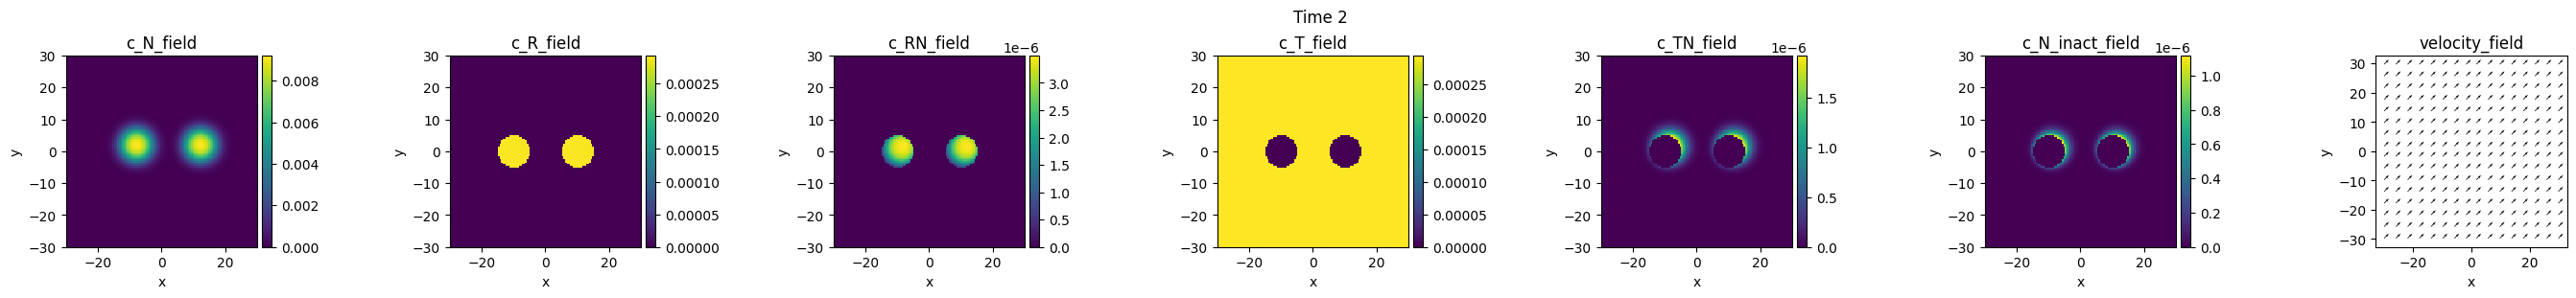

In [16]:
pde.movie(storage, filename="./Animations/multiple_synapses_1.mp4")